# Projeto da disciplina "Algoritmos de Inteligência Artificial para classificação [25E1_2]"
Aluna: **Rosana Ribeiro Lima**

## Link do código no Github:
https://github.com/roriblim/PD-algoritmos-IA-classificacao/


In [1]:
# Configurações CSS para conversão em HTML e impressão em PDF

from IPython.display import Image, display
from IPython.core.display import HTML

display(HTML("""
<style>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }
    .dataframe thead th {
        text-align: center;
    }
    .dataframe {
        width: 100% !important;  
        table-layout: fixed;  
        border-collapse: collapse; 
    }
    .dataframe td, .dataframe th {
        white-space: nowrap;
        font-size: 10px;  
        padding: 1px; 
    }
    th {  
        white-space: normal !important;
        word-wrap: break-word !important;
        text-align: center;
    }
    td { 
        white-space: nowrap !important;
    }
</style>
"""))

import sys
import warnings

# retirando os warnings
warnings.filterwarnings('ignore')


## 1. Módulo do Kaggle **"Intro to Machine Learning"**

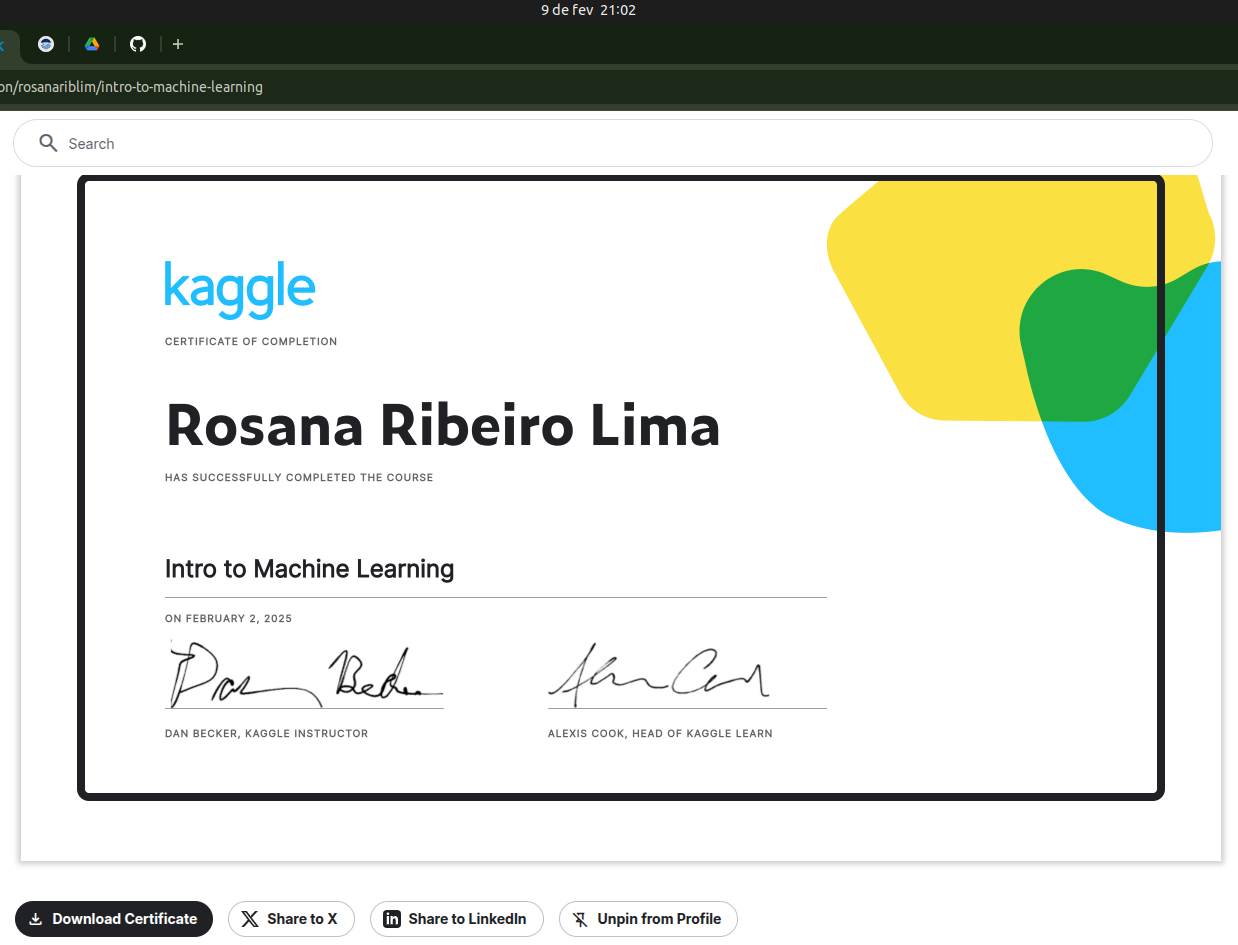

In [2]:
Image(filename="certificado-curso-kaggle-intro-to-ML.png",width=1000)

## 2. Carregando os dados os dados da base e criando a variável "opinion"

A proposta deste trabalho é analisarmos alguns classificadores a fim de identificar, em uma base de dados de vinho, quais vinhos podem ser considerados bons ou ruins, a partir de suas características.

Vamos carregar os dados, analisá-los e em seguida separar a base entre dados de vinho branco e dados de vinho tinto.
Conforme o enunciado, os dados de vinho branco serão utilizados para os itens 2 a 5.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, classification_report, roc_auc_score

PATH = 'winequalityN.csv'

data = pd.read_csv(PATH)
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   ph                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Vamos verificar agora se existem dados nulos a serem tratados na base:


type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
ph                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


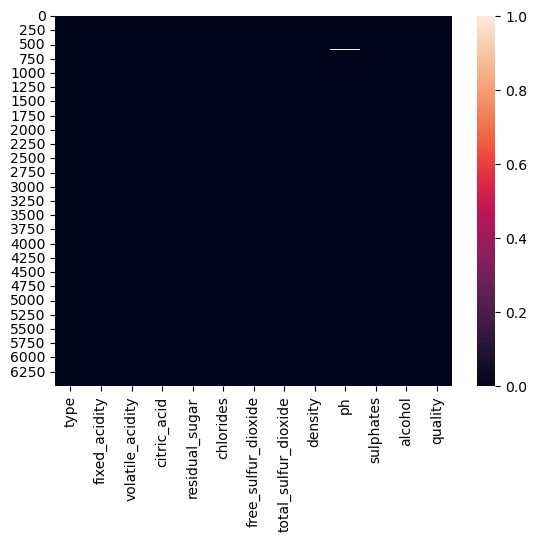

In [4]:
sns.heatmap(data.isna(), vmin=0, vmax=1)
print(data.isnull().sum())

Analisando rapidamente os dados, é possível verificar que **há alguns dados nulos** na nossa base a serem tratados (nas colunas fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, ph e sulphates). Uma possível forma de realizar o tratamento seria utilizando a média ou mediana dos valores nessa coluna. Mas para decidir isso, vamos analisar melhor a distribuição de dados nessas colunas:


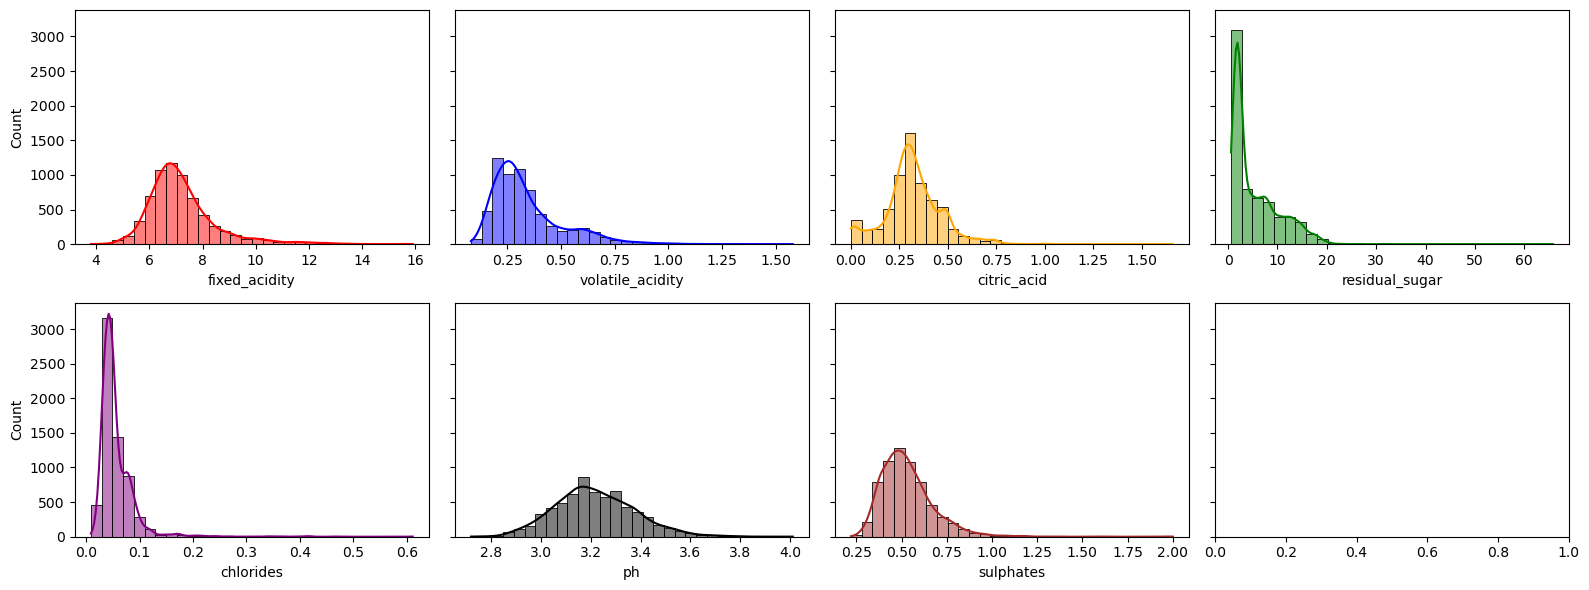

In [5]:

fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharey=True)

# Vamos verificar os histogramas das colunas que apresentam nulos
colunas_com_dados_faltantes = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'ph', 'sulphates']
colors = ['red', 'blue', 'orange', 'green', 'purple','black','brown']

# Vamos plotar o histograma de cada uma dessas colunas que apresenta dados nulos:
for i, ax in enumerate(axes.flat):
    if i < (len(colunas_com_dados_faltantes)):
        sns.histplot(data[colunas_com_dados_faltantes[i]], bins=30, kde=True, color=colors[i], edgecolor='black', ax=ax)

plt.tight_layout()
plt.show()



Em alguns desses atributos, a média aparenta ser uma boa forma de substituir os dados nulos (nas curvas que apresentam a distribuição mais normal, como a fixed_acidity). Mas o mesmo não ocorre em outras colunas (por exemplo, no caso do residual_sugar, a média traria um dado mais deslocado). Além disso, a presença de outliers (por exemplo, em volatile_acidity) deixa o resultado da média um pouco sujo. Portanto, nesse caso, uma maneira mais robusta de substituir esses dados faltantes é utilizando então a mediana.

In [6]:
# tratando os dados nulos substituindo pela mediana:
data[colunas_com_dados_faltantes] = data[colunas_com_dados_faltantes].fillna(data[colunas_com_dados_faltantes].median())

# não deve ter mais dados nulos:
print(data.isnull().sum())

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# por fim, vamos remover eventuais entradas duplicadas na nossa base:
print("====LINHAS E COLUNAS ANTES DA REMOÇÃO DE DUPLICATAS====")
print(data.shape)
data = data.drop_duplicates()
print("====LINHAS E COLUNAS APÓS A REMOÇÃO DE DUPLICATAS====")
print(data.shape)

====LINHAS E COLUNAS ANTES DA REMOÇÃO DE DUPLICATAS====
(6497, 13)
====LINHAS E COLUNAS APÓS A REMOÇÃO DE DUPLICATAS====
(5329, 13)


Vemos que a base foi reduzida a pós a remoção das entradas duplicadas.

## Separação entre dados de vinho branco e de vinho tinto

Agora, vamos verificar os valores presentes em "type", a coluna que utilizaremos para separar em dados de vinho branco e de vinho tinto.

In [8]:
# antes de fazer a separação, vamos analisar os dados presentes em type:
data['type'].value_counts(normalize = True)

type
white    0.74498
red      0.25502
Name: proportion, dtype: float64

Verificamos que mais de 74% das entradas da nossa base correspondem a dados de vinho branco. 
Vamos agora realizar a separação.

In [9]:
# separando os dados de vinho branco e os dados de vinho tinto:
data_v_brancos = data[data['type'] == 'white']
data_v_tinto = data[data['type'] == 'red']

# verificando o novo tamanho das bases:
print(data_v_brancos.shape)
print(data_v_tinto.shape)

(3970, 13)
(1359, 13)


Agora, para as questões 2 a 5, conforme o enunciado, vamos utilizar somente data_v_brancos. Vamos criar a variável "opinion" a partir de "quality". Primeiro vamos analisar os dados de "quality", vendo os valores por ela assumidos:

In [10]:
# analisando quality para a base de vinhos brancos:
data_v_brancos['quality'].value_counts()

quality
6    1792
5    1178
7     690
4     153
8     132
3      20
9       5
Name: count, dtype: int64

In [11]:
# criando opinion para a base de vinhos tintos:
data_v_tinto_opinion = data_v_tinto.copy()
data_v_tinto_opinion.loc[:, 'opinion'] = data_v_tinto['quality'].apply(lambda value: 0 if value <= 5 else 1)

# descartando a coluna quality:
data_v_tinto_opinion = data_v_tinto_opinion.drop('quality', axis=1)


#------------------------------------------------------------

# criando opinion para a base de vinhos brancos:
data_v_brancos_opinion = data_v_brancos.copy()
data_v_brancos_opinion.loc[:, 'opinion'] = data_v_brancos['quality'].apply(lambda value: 0 if value <= 5 else 1)

# descartando a coluna quality:
data_v_brancos_opinion = data_v_brancos_opinion.drop('quality', axis=1)
data_v_brancos_opinion.head()



,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,opinion
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
6,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,1


Em seguida, verificamos a distribuição de valores na nova variável "opinion", que será nossa classificação dos dados:

In [12]:
data_v_brancos_opinion['opinion'].value_counts()

opinion
1    2619
0    1351
Name: count, dtype: int64

Dessa análise, podemos perceber que nossa base de dados não está balanceada, e portanto devemos usar a estratificação para garantir que nossas classes estarão bem distribuídas entre treino e teste.

# 3. Descrevendo as variáveis presentes na base



Com a análise feita abaixo, é possível perceber quais as variáveis do dataset de vinhos brancos:

* **type** - variável categórica que contém nomes dos tipos de vinho ("white" ou "red")
  
* **fixed_acidity** - variável contínua numérica

  
* **volatile_acidity** - variável contínua numérica

  
* **citric_acid** - variável contínua numérica

  
* **residual_sugar** - variável contínua numérica

  
* **chlorides** - variável contínua numérica

  
* **free_sulfur_dioxide** - variável discreta numérica (assume apenas valores inteiros)

  
* **total_sulfur_dioxide** - variável discreta numérica (assume apenas valores inteiros)

  
* **density** - variável contínua numérica

  
* **pH** - variável contínua numérica

  
* **sulphates** - variável contínua numérica

  
* **alcohol** - variável contínua numérica

  
* **opinion** - variável categórica binária (no caso, 0 ou 1)


In [13]:
print(data_v_brancos_opinion.info())

# vamos analisar rapidamente os dados verificando algumas entradas
data_v_brancos_opinion.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 3970 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3970 non-null   object 
 1   fixed_acidity         3970 non-null   float64
 2   volatile_acidity      3970 non-null   float64
 3   citric_acid           3970 non-null   float64
 4   residual_sugar        3970 non-null   float64
 5   chlorides             3970 non-null   float64
 6   free_sulfur_dioxide   3970 non-null   float64
 7   total_sulfur_dioxide  3970 non-null   float64
 8   density               3970 non-null   float64
 9   ph                    3970 non-null   float64
 10  sulphates             3970 non-null   float64
 11  alcohol               3970 non-null   float64
 12  opinion               3970 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 434.2+ KB
None


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,opinion
0,white,7.0,0.27,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
6,white,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,1
9,white,8.1,0.22,0.43,1.50,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,1
10,white,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0,0
11,white,8.6,0.23,0.40,4.20,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,0
12,white,7.9,0.18,0.37,1.20,0.040,16.0,75.0,0.9920,3.18,0.63,10.8,0
13,white,6.6,0.16,0.40,1.50,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,1


Como todos os vinhos a serem tratados na base **data_v_brancos_opinion** pertencem ao tipo "white" (não existe outro tipo nesse conjunto de vinhos brancos), e por se tratar de um dado categórico que não terá média nem desvio-padrão, podemos retirá-lo do nosso dataframe. Em seguida calculamos as médias e os desvios:

In [14]:
data_v_brancos_opinion = data_v_brancos_opinion.drop(columns=['type'])
print("====Médias das variáveis:====")
print(data_v_brancos_opinion.mean())
print()
print("====Desvios-padrão das variáveis:====")
print(data_v_brancos_opinion.std())
print()

====Médias das variáveis:====
fixed_acidity             6.841196
volatile_acidity          0.280657
citric_acid               0.334539
residual_sugar            5.919018
chlorides                 0.045896
free_sulfur_dioxide      34.909698
total_sulfur_dioxide    137.248992
density                   0.993792
ph                        3.195335
sulphates                 0.490408
alcohol                  10.588324
opinion                   0.659698
dtype: float64

====Desvios-padrão das variáveis:====
fixed_acidity            0.865557
volatile_acidity         0.103486
citric_acid              0.122450
residual_sugar           4.863857
chlorides                0.023079
free_sulfur_dioxide     17.218706
total_sulfur_dioxide    43.133975
density                  0.002905
ph                       0.151346
sulphates                0.113567
alcohol                  1.217302
opinion                  0.473870
dtype: float64



Podemos ainda verificar mais algumas características dos dados, como os valores mínimos e máximos assumidos pelas features:


In [15]:
# verificando alguns dados estatísticos das features arredondando para três casas decimais:
data_v_brancos_opinion.drop('opinion', axis=1).describe().round(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
count,3970.000,3970.000,3970.000,3970.000,3970.000,3970.000,3970.000,3970.000,3970.000,3970.000,3970.000
mean,6.841,0.281,0.335,5.919,0.046,34.910,137.249,0.994,3.195,0.490,10.588
std,0.866,0.103,0.122,4.864,0.023,17.219,43.134,0.003,0.151,0.114,1.217
min,3.800,0.080,0.000,0.600,0.009,2.000,9.000,0.987,2.720,0.220,8.000
25%,6.300,0.210,0.270,1.600,0.036,23.000,106.000,0.992,3.090,0.410,9.500
50%,6.800,0.260,0.320,4.700,0.042,33.000,133.000,0.994,3.180,0.480,10.400
75%,7.300,0.329,0.390,8.900,0.050,45.000,166.000,0.996,3.290,0.550,11.400
max,14.200,1.100,1.660,65.800,0.346,289.000,440.000,1.039,3.820,1.080,14.200


No nosso caso, como já verificamos que algumas das features têm muitos outliers, e como algumas têm valores muito maiores do que outras, será interessante realizar um escalonamento robusto na pipeline do classificador.

Agora, mais um passo importante é realizarmos a separação dos dados adequadamente:

In [16]:
# separando features (dados de entrada) dos targets (dados que queremos prever)
x_brancos = data_v_brancos_opinion.drop('opinion', axis=1)
y_brancos = data_v_brancos_opinion[['opinion']]

x_brancos_train, x_brancos_test, y_brancos_train, y_brancos_test = train_test_split(x_brancos, y_brancos, 
                                                                                    test_size=0.2, 
                                                                                    random_state=10, 
                                                                                    stratify=y_brancos)



In [17]:
# vamos realizar a limpeza da coluna "type" também nos dados de vinho tinto:
data_v_tinto_opinion = data_v_tinto_opinion.drop(columns=['type'])

# vamos fazer a separação também para os dados de vinho tinto, que será importante no item 6.
x_tintos = data_v_tinto_opinion.drop('opinion', axis=1)
y_tintos = data_v_tinto_opinion[['opinion']]


# 4. Criação dos modelos

## 4.a. Etapas necessárias para criar um modelo de classificação eficiente

Algumas verificações e etapas são importantes na criação de um modelo eficiente: podemos citar a análise e o tratamento dos dados, a separação dos dados de treino e teste, a escolha de um bom modelo, a escolha dos melhores hiperparâmetros e a escolha da melhor métrica de performance do modelo. Cada um está melhor descrito a seguir:

#### Análise e tratamento dos dados
* No caso da análise e tratamento dos dados, que corresponde à etapa de pré-processamento, deve ser feito todo o tratamento que tem como finalidade deixar os dados com qualidade, utilizáveis da melhor forma pelo classificador.
* Por exemplo, devem ser tratados eventuais dados nulos, como o que fizemos acima (pelo descarte ou pela substituição por algum valor, de forma adequada). Também é interessante o descarte de dados repetidos, como o que fizemos acima.
* Além disso, deve-se verificar se os dados são representativos do que se quer classificar (por exemplo, verificando se a base está balanceada; caso não esteja, usar estratégias de estratificação dos dados se torna importante).
* Também, deve ser escolhida a melhor forma de lidar com outliers (por exemplo, por meio de um escalonamento robusto), ou ainda, não havendo muitos outliers, pode ser feito o escalonamento padrão. Com o escalonamento, podemos evitar que features contendo variáveis com valores muito superiores que outras tenham um peso maior no classificador. Além disso, fica mais fácil entender quais features têm mais peso na análise final.
* Outro tratamento importante é com relação a variáveis categóricas: deve-se analisar se elas serão importantes para o modelo e, caso sejam, de que forma será feita essa transformação para que esses dados sejam aproveitados no modelo (exemplo: One-Hot encoding, ou então Label encoding).

#### Separação de dados de treino e de teste
* A separação dos dados de treino e teste, por sua vez, são importantes para que não haja vazamento de dados, diminuindo o risco de que o modelo fique enviesado. Além disso, caso tenhamos um conjunto grande de dados, pode ser interessante separar os dados em três grupos: um de treino, um de validação (para o ajuste dos hiperparâmetros do modelo), e um de teste (que vai determinar de fato a performance do modelo). Assim, evitamos que tenhamos resultados enviesados.
* Podemos ainda utilizar a validação cruzada, que separa os dados em diversos grupos menores e realiza diversas iterações, em cada iteração considerando uma possibilidade de separação dos dados entre treino e teste. Ao final, pegamos a média dos resultados registrados.

#### Escolha de um bom modelo
* A escolha do melhor tipo de modelo (por exemplo, Árvore de Decisão ou Regressão Logística, etc) para o caso depende do conhecimento do que se deseja, e também da análise prévia dos dados. Por exemplo, um modelo de separabilidade linear, como a regressão logística, pode ser muito útil se os dados demonstrarem ser linearmente separáveis. **Contudo, não devemos confundir regressão logística de regressão linear: apesar de ambos serem muito bons para dados linearmente separáveis, eles têm uma diferença fundamental: a regressão logística é um classificador (para targets de valores discretos)**, enquanto a regressão linear se trata de uma forma de regressão (para targets de valores contínuos). Basicamente, enquanto a regressão linear procura calcular uma função linear para encontrar os valores previstos (portanto, os valores dos targets têm infinitas possibilidades), a regressão logística é calculada pela sigmoide da função linear, o que permite agrupar todos os valores dos dados em targets que ficam entre 0 e 1. Esse valor indicará a probabilidade daquela entrada de dados corresponder ao target 1.

#### Ajuste dos hiperparâmetros
* O ajuste dos hiperparâmetros permite encontrar hiperparâmetros que vão ajudar a ter um modelo mais performático. Para isso, o ideal é usar um conjunto de dados de validação (além do conjunto de treino e teste, para não haver vazamento de dados), ou ainda utilizar a validação cruzada (que permitirá validar cada configuração de modelo para diversas configurações possíveis de dados de treino e teste).
* O ajuste pode ser realizado de diversas formas, como o GridSearch, o RandomSearch, entre outras.

#### Escolha da métrica de performance
* Outro passo importante é a escolha da melhor métrica de performance. Um modelo eficiente depende das necessidades de negócio. Por exemplo, pode ser mais importante para mim não ter falsos positivos do que o risco de ter falsos negativos, e vice-versa (nesse caso, a métrica utilizada pode variar entre a precisão e o recall, por exemplo).
* Ou ainda, posso ter métricas de negócio personalizadas para o meu caso (falsos positivos podem receber uma pontuação, verdadeiros positivos, outra, e assim por diante).

#### **Etapas seguintes do nosso modelo**

**No nosso caso**, a seguir, como já tratamos previamente os dados, vamos agora criar uma pipeline para esse modelo. Nessa pipeline, incluiremos:
* o **escalonamento robusto** que queremos implementar, a fim de equilibrar os pesos das features, e a fim de lidar melhor com os outliers que temos em nossa base;
* e o modelo de classificação (testaremos os casos com regressão logística, árvore de decisão e SVM)

Em seguida, definimos o param_grid com as configurações de hiperparâmetros que queremos testar (para fazer o ajuste dos parâmetros do modelo), e definimos a validação cruzada estratificada (onde serão separados os dados de treino e validação).

Definimos ainda as métricas que queremos encontrar e, por fim, realizamos o treinamento com o GridSearchCV ou RandomSearchCV. Aqui, vamos considerar o melhor modelo aquele que tenha melhor f1-score, tendo em vista que os dados estão desbalanceados e também porque queremos equilibrar a importância da precisão e do recall.


## 4.b. Treinando um modelo de **Regressão Logística** usando um modelo de validação cruzada estratificada com k-folds (k=10)



In [18]:
# pipeline com o escalonador robusto e com o modelo de Regressão Logística
pipeline_rl = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(solver='saga', random_state=10))
])

# grid de parâmetros que serão testados no gridSearch
param_grid_rl = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight':['balanced', None]
}

# definindo o StratifiedKFold
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# definindo as métricas que queremos encontrar para cada modelo
metricas = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(accuracy_score),
    "recall": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score)
}

# configurar o buscador considerando a métrica do f1-score para encontrar o melhor modelo
search_rl = GridSearchCV(
    estimator=pipeline_rl,
    param_grid=param_grid_rl,
    scoring=metricas,
    cv=splitter,
    refit='f1',
    error_score=0,
    verbose = 0
)

# realizando o treinamento para encontrar os melhores hiperparâmetros e os resultados da validação cruzada
search_rl.fit(x_brancos_train, y_brancos_train.squeeze())

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model',
                                        LogisticRegression(random_state=10,
                                                           solver='saga'))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__class_weight': ['balanced', None],
                         'model__l1_ratio': [0.25, 0.5, 0.75],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(accuracy_score, response_method='predict'),
                      'recall': make_scorer(accuracy_score, response_method='predict')})

#### Média e Desvio-padrão da Acurácia, Precisão, F1-Score e Recall (Regressão Logística):

Agora vamos encontrar a média e o desvio-padrão das métricas desejadas (Acurácia, Precisão, F1-Score e Recall) a partir dos modelos treinados no GridSearchCV. Em seguida vamos printar uma tabela com as configurações de modelo e suas respectivas médias e desvio-padrão das métricas:


In [19]:
# Criando dataframe com os resultados:
resultados_modelos_rl = pd.DataFrame({
    'penalty': [model['model__penalty'] for model in search_rl.cv_results_['params']],
    'C': [model['model__C'] for model in search_rl.cv_results_['params']],
    'l1_ratio': [model['model__l1_ratio'] for model in search_rl.cv_results_['params']],
    'class_weight': [model['model__class_weight'] for model in search_rl.cv_results_['params']],
    'mean_accuracy': search_rl.cv_results_['mean_test_accuracy'],
    'std_accuracy': search_rl.cv_results_['std_test_accuracy'],
    'mean_precision': search_rl.cv_results_['mean_test_precision'],
    'std_precision': search_rl.cv_results_['std_test_precision'],
    'mean_recall': search_rl.cv_results_['mean_test_recall'],
    'std_recall': search_rl.cv_results_['std_test_recall'],
    'mean_f1': search_rl.cv_results_['mean_test_f1'],
    'std_f1': search_rl.cv_results_['std_test_f1']

})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Ordenando pelo melhor f1-score
resultados_modelos_rl = resultados_modelos_rl.sort_values(by='mean_f1', ascending=False)

# Mostrar os modelos (combinações de hiperparâmetros) e seus respectivos resultados de média e desvio-padrão de acurácia
print("===============RESULTADOS PARA A REGRESSÃO LOGÍSTICA=============")
resultados_modelos_rl.head(50)




===============RESULTADOS PARA A REGRESSÃO LOGÍSTICA=============


,penalty,C,l1_ratio,class_weight,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
119,None,10.000,0.75,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
63,None,0.100,0.25,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
91,None,1.000,0.50,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
95,None,1.000,0.75,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
19,None,0.001,0.50,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
43,None,0.010,0.50,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
47,None,0.010,0.75,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
67,None,0.100,0.50,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
23,None,0.001,0.75,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
71,None,0.100,0.75,None,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679


## 4.c. Treinando um modelo de **Árvore de Decisão** usando um modelo de validação cruzada estratificada com k-folds (k=10)


In [20]:
# pipeline com o escalonador robusto e com o modelo de Árvore de decisão
pipeline_dt = Pipeline([
    ('scaler', RobustScaler()),
    ('model', DecisionTreeClassifier(random_state=10))
])

# grid de parâmetros que serão testados no gridSearch
params_grid_dt = {
    'model__max_depth': range(1, 14),
    'model__criterion': ['gini', 'entropy']
}
# definindo o StratifiedKFold
splitter_dt = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# definindo as métricas que queremos encontrar para cada modelo
metricas = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(accuracy_score),
    "recall": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score)
}

# configurar o buscador considerando a métrica do f1-score para encontrar o melhor modelo
search_dt = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=params_grid_dt,
    scoring=metricas,
    cv=splitter_dt,
    refit='f1',
    error_score=0,
    verbose = 1
)

# realizando o treinamento para encontrar os melhores hiperparâmetros e os resultados da validação cruzada
search_dt.fit(x_brancos_train, y_brancos_train.squeeze())

Fitting 10 folds for each of 26 candidates, totalling 260 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=10))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(1, 14)},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(accuracy_score, response_method='predict'),
                      'recall': make_scorer(accuracy_score, response_method='predict')},
             verbose=1)

#### Média e Desvio-padrão da Acurácia, Precisão, F1-Score e Recall (Ávore de decisão):

Agora vamos encontrar a média e o desvio-padrão das métricas desejadas (Acurácia, Precisão, F1-Score e Recall) a partir dos modelos treinados no GridSearchCV. Em seguida vamos printar uma tabela com as configurações de modelo e suas respectivas médias e desvio-padrão das métricas:

In [21]:
# Criando dataframe com os resultados:
resultados_modelos_dt = pd.DataFrame({
    'max_depth': [model['model__max_depth'] for model in search_dt.cv_results_['params']],
    'criterion': [model['model__criterion'] for model in search_dt.cv_results_['params']],
    'mean_accuracy': search_dt.cv_results_['mean_test_accuracy'],
    'std_accuracy': search_dt.cv_results_['std_test_accuracy'],
    'mean_precision': search_dt.cv_results_['mean_test_precision'],
    'std_precision': search_dt.cv_results_['std_test_precision'],
    'mean_recall': search_dt.cv_results_['mean_test_recall'],
    'std_recall': search_dt.cv_results_['std_test_recall'],
    'mean_f1': search_dt.cv_results_['mean_test_f1'],
    'std_f1': search_dt.cv_results_['std_test_f1']

})

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

# Ordenando pelo melhor f1-score
resultados_modelos_dt = resultados_modelos_dt.sort_values(by='mean_f1', ascending=False)

# Mostrar os modelos (combinações de hiperparâmetros) e seus respectivos resultados de média e desvio-padrão de acurácia
print("===============RESULTADOS PARA A ÁRVORE DE DECISÃO=============")
resultados_modelos_dt




===============RESULTADOS PARA A ÁRVORE DE DECISÃO=============


,max_depth,criterion,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
3,4,gini,0.743404,0.020204,0.743404,0.020204,0.743404,0.020204,0.814422,0.012164
2,3,gini,0.741825,0.015242,0.741825,0.015242,0.741825,0.015242,0.810552,0.014516
17,5,entropy,0.738369,0.028022,0.738369,0.028022,0.738369,0.028022,0.808277,0.022048
1,2,gini,0.735527,0.017324,0.735527,0.017324,0.735527,0.017324,0.808154,0.012418
16,4,entropy,0.741207,0.030601,0.741207,0.030601,0.741207,0.030601,0.808062,0.023496
15,3,entropy,0.732067,0.015216,0.732067,0.015216,0.732067,0.015216,0.806154,0.010817
4,5,gini,0.736780,0.024902,0.736780,0.024902,0.736780,0.024902,0.803372,0.019076
14,2,entropy,0.723881,0.017014,0.723881,0.017014,0.723881,0.017014,0.802858,0.014985
18,6,entropy,0.732072,0.029861,0.732072,0.029861,0.732072,0.029861,0.802447,0.022295
7,8,gini,0.730154,0.024309,0.730154,0.024309,0.730154,0.024309,0.799296,0.018051


## 4.d. Treinando um modelo de **SVM** (Support Vector Machine) usando um modelo de validação cruzada estratificada com k-folds (k=10)



In [22]:
# pipeline com o escalonador robusto e com o modelo de Árvore de decisão
pipeline_svm = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVC(random_state=10, probability=True))
])

# aqui utilizaremos o randomsearch, para tentar otimizar a busca dos parâmetros;
# faremos isso tendo em vista as diversas possibilidades do SVM
# e tendo em vista seu treinamento demorar mais do que a Regressão Logística ou a Árvore de decisão
# grid de parâmetros que serão testados
param_grid_svm = {
    'model__C': np.random.uniform(0.01,10,20),
    'model__kernel': ['linear', 'rbf','sigmoid','poly'],
    'model__gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'model__degree': [2, 3],
    'model__class_weight': ['balanced', None]
}


# definindo o StratifiedKFold
splitter_svm = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# definindo as métricas que queremos encontrar para cada modelo
metricas = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(accuracy_score),
    "recall": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score)
}

# configurar o buscador considerando a métrica do f1-score para encontrar o melhor modelo
search_svm = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=param_grid_svm,
    scoring=metricas,
    cv=splitter_svm,
    n_iter=23,
    refit='f1',
    error_score=0,
    verbose = 0
)

# realizando o treinamento para encontrar os melhores hiperparâmetros e os resultados da validação cruzada
search_svm.fit(x_brancos_train, y_brancos_train.squeeze())

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              SVC(probability=True,
                                                  random_state=10))]),
                   n_iter=23,
                   param_distributions={'model__C': array([5.42644563, 6.46940426, 1.73290346, 4.81183167, 3.747125  ,
       1.37005107, 9.26102236, 8.8024172 , 8.17148338, 4.7279475...
                                        'model__gamma': ['scale', 0.001, 0.01,
                                                         0.1, 1],
                                        'model__kernel': ['linear', 'rbf',
                                                          'sigmoid', 'poly']},
                   refit='f1',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(accuracy_score, response_method='predict'),
                            'recall': make_scorer(accuracy_score, response_method='predict')})

#### Média e Desvio-padrão da Acurácia, Precisão, F1-Score e Recall (SVM):

Agora vamos encontrar a média e o desvio-padrão das métricas desejadas (Acurácia, Precisão, F1-Score e Recall) a partir dos modelos treinados no GridSearchCV. Em seguida vamos printar uma tabela com as configurações de modelo e suas respectivas médias e desvio-padrão das métricas:

In [23]:
# Criando dataframe com os resultados da acurácia:
resultados_modelos_svm = pd.DataFrame({
    'C': [model['model__C'] for model in search_svm.cv_results_['params']],
    'kernel': [model['model__kernel'] for model in search_svm.cv_results_['params']],
    'gamma': [model['model__gamma'] for model in search_svm.cv_results_['params']],
    'degree': [model['model__degree'] for model in search_svm.cv_results_['params']],
    'mean_accuracy': search_svm.cv_results_['mean_test_accuracy'],
    'std_accuracy': search_svm.cv_results_['std_test_accuracy'],
    'mean_precision': search_svm.cv_results_['mean_test_precision'],
    'std_precision': search_svm.cv_results_['std_test_precision'],
    'mean_recall': search_svm.cv_results_['mean_test_recall'],
    'std_recall': search_svm.cv_results_['std_test_recall'],
    'mean_f1': search_svm.cv_results_['mean_test_f1'],
    'std_f1': search_svm.cv_results_['std_test_f1']

})

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

# Ordenando pelo melhor F1-Score
resultados_modelos_svm = resultados_modelos_svm.sort_values(by='mean_f1', ascending=False)

# Mostrar os modelos (combinações de hiperparâmetros) e seus respectivos resultados de média e desvio-padrão de acurácia
resultados_modelos_svm




,C,kernel,gamma,degree,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
16,1.063352,rbf,1,2,0.749385,0.016149,0.749385,0.016149,0.749385,0.016149,0.825778,0.010497
13,8.802417,rbf,scale,3,0.760087,0.019203,0.760087,0.019203,0.760087,0.019203,0.823943,0.014658
1,6.435724,linear,0.001,2,0.748752,0.019992,0.748752,0.019992,0.748752,0.019992,0.820464,0.014324
20,6.469404,linear,0.001,2,0.748438,0.019920,0.748438,0.019920,0.748438,0.019920,0.820280,0.014265
21,5.426446,poly,scale,3,0.732378,0.022542,0.732378,0.022542,0.732378,0.022542,0.819512,0.015322
14,4.727948,sigmoid,0.001,3,0.716954,0.020719,0.716954,0.020719,0.716954,0.020719,0.815588,0.012209
11,1.732903,rbf,0.001,3,0.707505,0.017382,0.707505,0.017382,0.707505,0.017382,0.812555,0.010288
22,1.370051,rbf,1,2,0.741183,0.012105,0.741183,0.012105,0.741183,0.012105,0.808200,0.010406
5,6.469404,poly,0.1,2,0.702145,0.015088,0.702145,0.015088,0.702145,0.015088,0.806274,0.010294
12,2.538952,poly,scale,2,0.699623,0.014194,0.699623,0.014194,0.699623,0.014194,0.805672,0.009634


## 5. Comparando e escolhendo modelos - análise e curva ROC


In [24]:
# podemos agora ver os melhores modelos obtidos a partir de cada GridSearchCV, e seus respectivos resultados, para compará-los:

pd.set_option('display.max_colwidth', None)

print("-------------------------------------MELHOR MODELO DE CADA---------------------------------")
print()
melhores_modelos = {
    'modelo':['Decision Tree','Regressão Logística','SVM'],
    'best_index': [search_dt.best_index_, search_rl.best_index_, search_svm.best_index_],
    'parâmetros do melhor modelo': [search_dt.best_estimator_[1], search_rl.best_estimator_[1], search_svm.best_estimator_[1]],
}
melhores_modelos_df = pd.DataFrame(melhores_modelos)

print(melhores_modelos_df)

print()
print("-------------------------------------MÉTRICAS DO MELHOR MODELO DE CADA---------------------------------")
print()

melhores_modelos_resultado = {
    'modelo':['Decision Tree','Regressão Logística','SVM'],

    'best_index': [search_dt.best_index_, search_rl.best_index_, search_svm.best_index_],

    'mean_accuracy': [search_dt.cv_results_['mean_test_accuracy'][search_dt.best_index_],
                      search_rl.cv_results_['mean_test_accuracy'][search_rl.best_index_],
                      search_svm.cv_results_['mean_test_accuracy'][search_svm.best_index_]],

    'std_accuracy': [search_dt.cv_results_['std_test_accuracy'][search_dt.best_index_],
                     search_rl.cv_results_['std_test_accuracy'][search_rl.best_index_],
                     search_svm.cv_results_['std_test_accuracy'][search_svm.best_index_]],

    'mean_precision': [search_dt.cv_results_['mean_test_precision'][search_dt.best_index_],
                       search_rl.cv_results_['mean_test_precision'][search_rl.best_index_],
                       search_svm.cv_results_['mean_test_precision'][search_svm.best_index_]],

    'std_precision': [search_dt.cv_results_['std_test_precision'][search_dt.best_index_],
                      search_rl.cv_results_['std_test_precision'][search_rl.best_index_],
                      search_svm.cv_results_['std_test_precision'][search_svm.best_index_]],

    'mean_recall': [search_dt.cv_results_['mean_test_recall'][search_dt.best_index_],
                    search_rl.cv_results_['mean_test_recall'][search_rl.best_index_],
                    search_svm.cv_results_['mean_test_recall'][search_svm.best_index_]],

    'std_recall': [search_dt.cv_results_['std_test_recall'][search_dt.best_index_],
                   search_rl.cv_results_['std_test_recall'][search_rl.best_index_],
                   search_svm.cv_results_['std_test_recall'][search_svm.best_index_]],

    'mean_f1': [search_dt.cv_results_['mean_test_f1'][search_dt.best_index_],
                search_rl.cv_results_['mean_test_f1'][search_rl.best_index_],
                search_svm.cv_results_['mean_test_f1'][search_svm.best_index_]],

    'std_f1': [search_dt.cv_results_['std_test_f1'][search_dt.best_index_],
               search_rl.cv_results_['std_test_f1'][search_rl.best_index_],
               search_svm.cv_results_['std_test_f1'][search_svm.best_index_]]
}

melhores_modelos_resultado_df = pd.DataFrame(melhores_modelos_resultado)

melhores_modelos_resultado_df


-------------------------------------MELHOR MODELO DE CADA---------------------------------

                modelo  best_index                                                                                   parâmetros do melhor modelo
0        Decision Tree           3                                                          DecisionTreeClassifier(max_depth=4, random_state=10)
1  Regressão Logística          15  LogisticRegression(C=0.001, l1_ratio=0.25, penalty=None, random_state=10,\n                   solver='saga')
2                  SVM          16                               SVC(C=1.0633516492745496, degree=2, gamma=1, probability=True, random_state=10)

-------------------------------------MÉTRICAS DO MELHOR MODELO DE CADA---------------------------------



,modelo,best_index,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
0,Decision Tree,3,0.743404,0.020204,0.743404,0.020204,0.743404,0.020204,0.814422,0.012164
1,Regressão Logística,15,0.749703,0.021236,0.749703,0.021236,0.749703,0.021236,0.820513,0.015679
2,SVM,16,0.749385,0.016149,0.749385,0.016149,0.749385,0.016149,0.825778,0.010497


Podemos agora verificar ainda as métricas dos melhores modelos de cada em relação aos dados de teste de vinho branco:

In [25]:
y_branco_pred_rl = search_rl.best_estimator_.predict(x_brancos_test)
y_branco_pred_dt = search_dt.best_estimator_.predict(x_brancos_test)
y_branco_pred_svm = search_svm.best_estimator_.predict(x_brancos_test)

print("RESULTADOS DA REGRESSÃO LOGÍSTICA COM OS DADOS DE TESTE DE VINHO BRANCO")
print(classification_report(y_brancos_test, y_branco_pred_rl))
print()

print("RESULTADOS DA ÁRVORE DE DECISÃO COM OS DADOS DE TESTE DE VINHO BRANCO")
print(classification_report(y_brancos_test, y_branco_pred_dt))
print()

print("RESULTADOS DA SVM COM OS DADOS DE TESTE DE VINHO BRANCO")
print(classification_report(y_brancos_test, y_branco_pred_svm))
print()

RESULTADOS DA REGRESSÃO LOGÍSTICA COM OS DADOS DE TESTE DE VINHO BRANCO
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       270
           1       0.79      0.86      0.82       524

    accuracy                           0.76       794
   macro avg       0.73      0.71      0.72       794
weighted avg       0.75      0.76      0.75       794


RESULTADOS DA ÁRVORE DE DECISÃO COM OS DADOS DE TESTE DE VINHO BRANCO
              precision    recall  f1-score   support

           0       0.68      0.54      0.60       270
           1       0.79      0.87      0.82       524

    accuracy                           0.76       794
   macro avg       0.73      0.70      0.71       794
weighted avg       0.75      0.76      0.75       794


RESULTADOS DA SVM COM OS DADOS DE TESTE DE VINHO BRANCO
              precision    recall  f1-score   support

           0       0.67      0.46      0.54       270
           1       0.76      0.88    

Podemos ainda traçar a curva ROC dos três modelos, considerando a melhor configuração de hiperparâmetros de cada e os dados de probabilidade obtidos após o gridSearchCV. A curva ROC é plotada a partir da probabilidade obtida pelo modelo para que determinado conjunto de features tenha target equivalente a 1. Assim, considerando esses dados de probabilidade (que aqui chamaremos de y_prob) e os valores reais esperados de target (y_brancos_test), a curva ROC é plotada considerando as várias possibilidades de fronteira de decisão (limiares de probabilidade que serão utilizados para determinar se o modelo considerará o target como 0 ou 1).

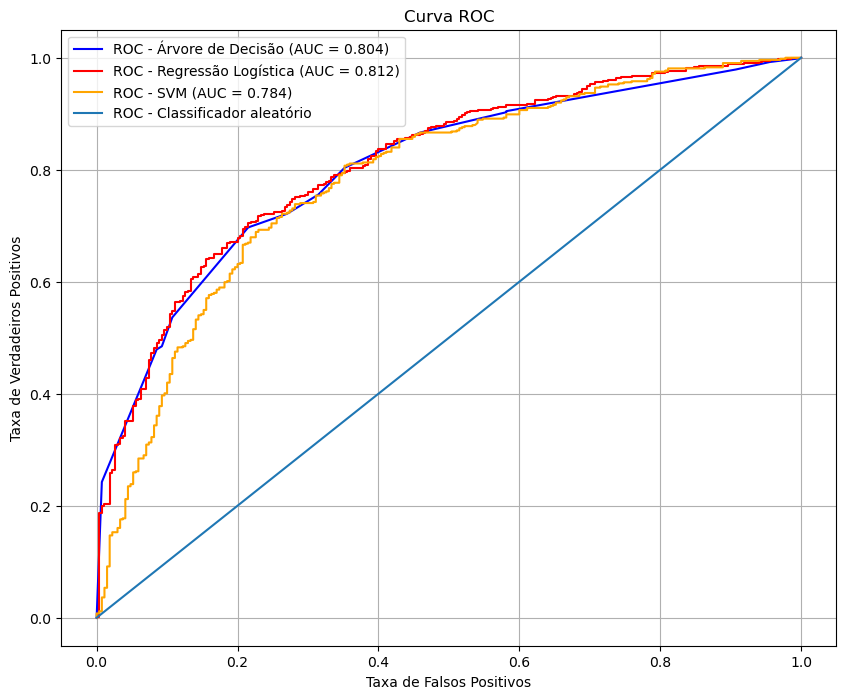

In [26]:
# obtendo os scores de probabilidade de cada modelo:
y_prob_dt = search_dt.best_estimator_.predict_proba(x_brancos_test)[:, 1]
y_prob_rl = search_rl.best_estimator_.predict_proba(x_brancos_test)[:, 1]
y_prob_svm = search_svm.best_estimator_.predict_proba(x_brancos_test)[:, 1]

# curva roc de cada modelo:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_brancos_test, y_prob_dt)
roc_auc_dt = roc_auc_score(y_brancos_test, y_prob_dt)

fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_brancos_test, y_prob_rl)
roc_auc_rl = roc_auc_score(y_brancos_test, y_prob_rl)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_brancos_test, y_prob_svm)
roc_auc_svm = roc_auc_score(y_brancos_test, y_prob_svm)


# plotando as curvas ROC:
plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, label=f'ROC - Árvore de Decisão (AUC = {roc_auc_dt:.3f})', color='blue')
plt.plot(fpr_rl, tpr_rl, label=f'ROC - Regressão Logística (AUC = {roc_auc_rl:.3f})', color='red')
plt.plot(fpr_svm, tpr_svm, label=f'ROC - SVM (AUC = {roc_auc_svm:.3f})', color='orange')
plt.plot([0, 1], [0, 1], label='ROC - Classificador aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()



Portanto, das curvas ROC plotadas, e também da comparação de métricas dos modelos, é possível ver que o modelo de regressão logística demonstrou ter uma performance melhor. Isso ocorre porque a área sob a curva ROC (AUC, ou *area under curve*) com o melhor modelo de regressão logística é maior do que a área sob a curva ROC dos demais modelos. A diferença é pequena, mas a AUC do classificador da regressão logística é 0.812 e da árvore de decisão é 0.804, enquanto do SVM é 0.784.

Além disso, a regressão logística demonstra ser uma boa escolha neste caso, dentre os modelos testados, porque, além de ter resultados de performance semelhantes (até um pouco melhores), seu treinamento é muito mais rápido do que o treinamento do modelo SVM.

A área sob a curva ROC é um bom indicativo de performance do modelo: quanto maior sua área, é um indicativo de que o modelo consegue ter uma taxa de verdadeiros positivos mais alta para uma taxa de falsos positivos mais baixa. Além disso, quanto mais o gráfico se aproximar do ponto (0,1), naquele ponto sua performance tende a ser maior, pois o ponto (0,1) corresponde ao ponto de taxa de falsos positivos igual a 0 e taxa de verdadeiros positivos igual a 1.

Outra forma de determinar esse ponto ótimo é pelo Índice de Youden (que é a diferença entre a taxa de verdadeiros positivos e a taxa de falsos positivos); quanto maior essa diferença, melhor a performance do modelo.

Vamos calcular, a título de conhecimento, o Índice de Youden para o modelo de regressão logística:

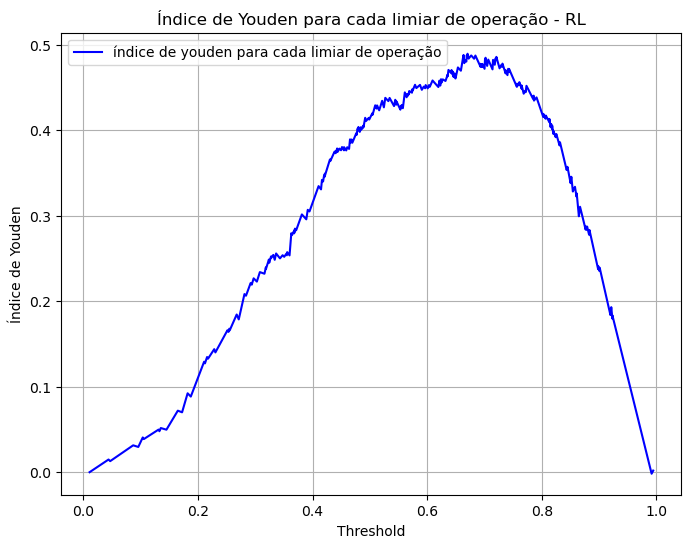


Melhor fronteira de decisão para o melhor modelo RL encontrado:
0.7384705146219417


In [30]:
# Índice de Youden
youden_index = tpr_rl - fpr_rl

plt.figure(figsize=(8, 6))
plt.plot(thresholds_rl, youden_index, label=f'índice de youden para cada limiar de operação', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Índice de Youden")
plt.title("Índice de Youden para cada limiar de operação - RL")
plt.legend()
plt.grid()
plt.show()

melhor_threshold_index = np.argmax(youden_index)
melhor_threshold = thresholds_svm[melhor_threshold_index]

print()
print("Melhor fronteira de decisão para o melhor modelo RL encontrado:")
print(melhor_threshold)

Assim, se quisermos utilizar o modelo encontrado de maneira ainda mais eficaz, uma boa ideia pode ser utilizar a melhor fronteira de decisão encontrada, ou algum valor entre 0.5 e essa melhor fronteira. Para o restante do trabalho, seguiremos utilizando a fronteira padrão, de 0.5, porque ela também demonstra ser uma boa fronteira neste caso, com bom índice de Youden.

## 6. Inferência dos dados de vinho tinto a partir dos modelos treinados
Podemos agora testar os modelos treinados e validados nos dados de vinho branco e utilizá-los para fazer a inferência nos dados de vinho tinto:

In [33]:
y_tintos_pred_rl = search_rl.best_estimator_.predict(x_tintos)
y_tintos_pred_dt = search_dt.best_estimator_.predict(x_tintos)
y_tintos_pred_svm = search_svm.best_estimator_.predict(x_tintos)

print("RESULTADOS DA REGRESSÃO LOGÍSTICA COM OS DADOS DE TESTE DE VINHO TINTO")
print(classification_report(y_tintos, y_tintos_pred_rl))
print()

print("RESULTADOS DA ÁRVORE DE DECISÃO COM OS DADOS DE TESTE DE VINHO TINTO")
print(classification_report(y_tintos, y_tintos_pred_dt))
print()

print("RESULTADOS DA SVM COM OS DADOS DE TESTE DE VINHO TINTO")
print(classification_report(y_tintos, y_tintos_pred_svm))
print()


RESULTADOS DA REGRESSÃO LOGÍSTICA COM OS DADOS DE TESTE DE VINHO TINTO
              precision    recall  f1-score   support

           0       0.58      0.94      0.72       640
           1       0.89      0.39      0.54       719

    accuracy                           0.65      1359
   macro avg       0.73      0.67      0.63      1359
weighted avg       0.74      0.65      0.63      1359


RESULTADOS DA ÁRVORE DE DECISÃO COM OS DADOS DE TESTE DE VINHO TINTO
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       640
           1       0.77      0.60      0.67       719

    accuracy                           0.69      1359
   macro avg       0.71      0.70      0.69      1359
weighted avg       0.71      0.69      0.69      1359


RESULTADOS DA SVM COM OS DADOS DE TESTE DE VINHO TINTO
              precision    recall  f1-score   support

           0       0.57      0.01      0.01       640
           1       0.53      1.00      0

É possível verificar que, à primeira vista, os resultados não foram tão bons quanto os obtidos para os vinhos brancos. Isso ocorre porque os dados de vinho branco podem ter alguma diferença para serem considerados de fato como "bom vinho" em relação aos dados de vinho tinto. O SVM também parece ter tido a maior queda de performance entre os três modelos.

Essa observação é importante porque demonstra que, ao utilizar um dataset para treinar nossos dados, ele deve ser representativo da população de dados a que de fato nosso modelo será submetido para análise. Nesse caso, nosso dataset de treinamento continha apenas vinhos brancos, enquanto nosso dataset de análise de inferência final continha apenas vinhos tintos. Para um melhor resultado, no caso real, o ideal seria que treinássemos sobre um dataset mais representativo (poderíamos por exemplo, treinar sobre vinhos tintos e brancos).

Para verificar isso com clareza, vamos plotar também as curvas ROC:

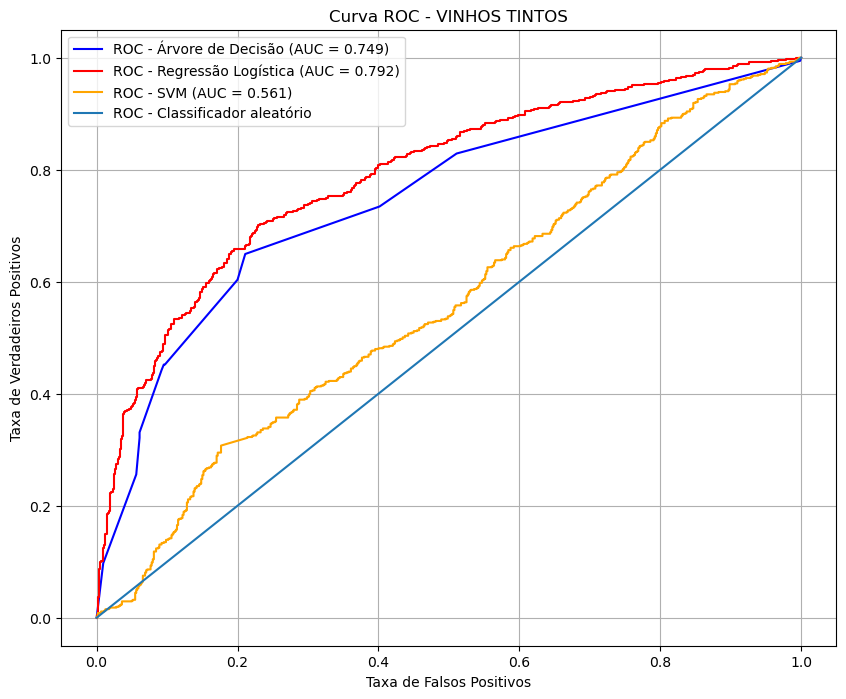

In [29]:
# obtendo os scores de probabilidade de cada modelo (VINHO TINTO):
y_prob_dt_tintos = search_dt.best_estimator_.predict_proba(x_tintos)[:, 1]
y_prob_rl_tintos = search_rl.best_estimator_.predict_proba(x_tintos)[:, 1]
y_prob_svm_tintos = search_svm.best_estimator_.predict_proba(x_tintos)[:, 1]

# curva roc de cada modelo (VINHO TINTO):
fpr_dt_tintos, tpr_dt_tintos, thresholds_dt_tintos = roc_curve(y_tintos, y_prob_dt_tintos)
roc_auc_dt_tintos = roc_auc_score(y_tintos, y_prob_dt_tintos)

fpr_rl_tintos, tpr_rl_tintos, thresholds_rl_tintos = roc_curve(y_tintos, y_prob_rl_tintos)
roc_auc_rl_tintos = roc_auc_score(y_tintos, y_prob_rl_tintos)

fpr_svm_tintos, tpr_svm_tintos, thresholds_svm_tintos = roc_curve(y_tintos, y_prob_svm_tintos)
roc_auc_svm_tintos = roc_auc_score(y_tintos, y_prob_svm_tintos)


# plotando as curvas ROC (VINHO TINTO):
plt.figure(figsize=(10, 8))
plt.plot(fpr_dt_tintos, tpr_dt_tintos, label=f'ROC - Árvore de Decisão (AUC = {roc_auc_dt_tintos:.3f})', color='blue')
plt.plot(fpr_rl_tintos, tpr_rl_tintos, label=f'ROC - Regressão Logística (AUC = {roc_auc_rl_tintos:.3f})', color='red')
plt.plot(fpr_svm_tintos, tpr_svm_tintos, label=f'ROC - SVM (AUC = {roc_auc_svm_tintos:.3f})', color='orange')
plt.plot([0, 1], [0, 1], label='ROC - Classificador aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - VINHOS TINTOS')
plt.legend()
plt.grid()
plt.show()


Podemos fazer uma interessante observação a partir da análise dessa curva ROC: o modelo SVM, que antes havia demonstrado bons resultados para a avaliação de vinhos brancos, não demonstrou ser um modelo tão robusto para os dados de vinho tinto. Já o modelo de regressão logística performou com os dados de vinho tinto de forma bastante parecida ao que havia performado com os dados de vinho branco.

Uma possível explicação para isso seria que as principais features e critérios identificados pelo modelo de Regressão Logística para realizar a classificação dos dados de vinho branco seriam também boas opções de critérios e features para classificação dos dados de vinho tinto. O mesmo não ocorre com o classificador SVM, apesar de ele ter tido um ótimo resultado na classificação de vinhos brancos, provavelmente os critérios por ele utilizados são mais restritos aos vinhos brancos. 

Vamos analisar então as features mais importantes percebidas pelo modelo de Regressão Logística (que foi o melhor modelo no caso dos vinhos brancos e também no caso dos vinhos tintos).

In [37]:
# analisando a importância das features no modelo de Regressão Logística:

search_rl.best_estimator_['model'].coef_

array([[ 0.02958023, -0.63535999,  0.03877627,  0.87426947, -0.02923136,
         0.35158336, -0.07827477, -0.84635748,  0.2611643 ,  0.28297118,
         1.49206298]])

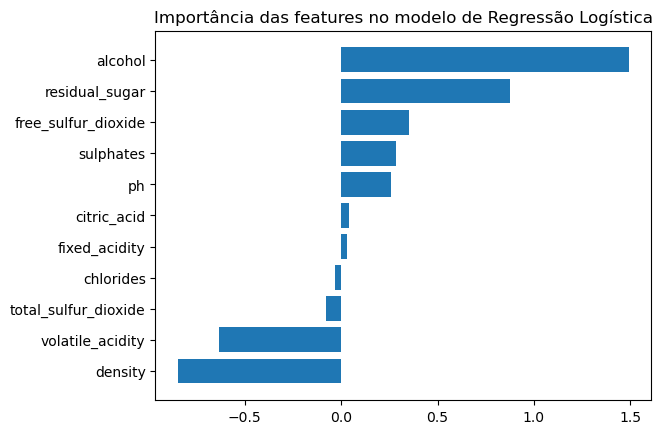

In [39]:
# Importância das features no modelo de Regressão Logística:

importance_rl = pd.DataFrame(x_brancos_train.columns, columns=['atributos'])
importance_rl['importancia'] = search_rl.best_estimator_['model'].coef_[0]
importance_rl.sort_values(by='importancia', inplace=True)

# construindo gráfico
plt.barh(y=importance_rl['atributos'], width=importance_rl['importancia'])
plt.title('Importância das features no modelo de Regressão Logística')
plt.show()

Podemos então concluir que o modelo de Regressão Logística demonstrou ser o mais robusto e flexível para o nosso dataset de vinhos, e as features que ele julgou mais importantes para a classificação são: alcohol, residual_sugar, density (de forma negativa) e volatile_acidity (também de forma negativa). 